# Colorization with autoencoders - celeba 32x32


### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import PIL
from tqdm.notebook import trange, tqdm
from PIL import Image
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from matplotlib import font_manager as fm, rcParams
from sklearn.model_selection import train_test_split

### Fonts

In [2]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Parameters

In [3]:
save_dir = '../../data/celeba/colorization/'
imgs_dir = '../../data/celeba/colorization/'

### Find all Data Files

In [9]:
data = {}
filenames = []
for root, dirs, files in os.walk("../../data/celeba/pickle/32x32/", topdown=False):
    for name in files:
        if '.p' in name:
            filenames.append(os.path.join(root, name))
filenames = np.sort(filenames)

### Read and store

In [10]:
datalist = []
y_combined = []
for i in range(2):
    data = pickle.load( open(filenames[i],"rb"))
    X = data['X']
    y = data['y']
    y_combined = y_combined + list(y['person_id'].values)
    datalist.append(X)
datatuple = tuple(datalist)
X = np.concatenate(datatuple)
y = np.array(y_combined)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### RGB to grayscale

In [11]:
def rgb2gray(rgb):

    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

### Plot some images 

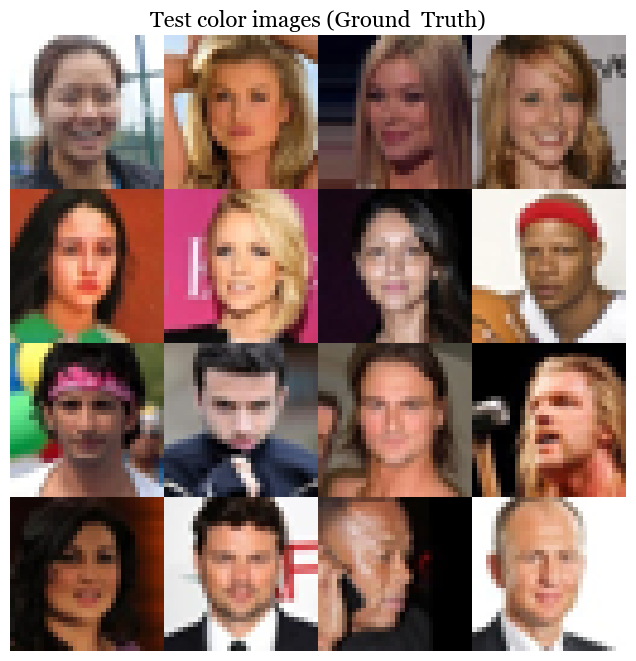

In [14]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]
imgs = x_test[:16]
imgs = imgs.reshape((4, 4, img_rows, img_cols, channels))
imgs_orig = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Test color images (Ground  Truth)',**csfont,fontsize=16)
plt.imshow(imgs_orig, interpolation='none')
plt.show()

### Convert to gray and plot again

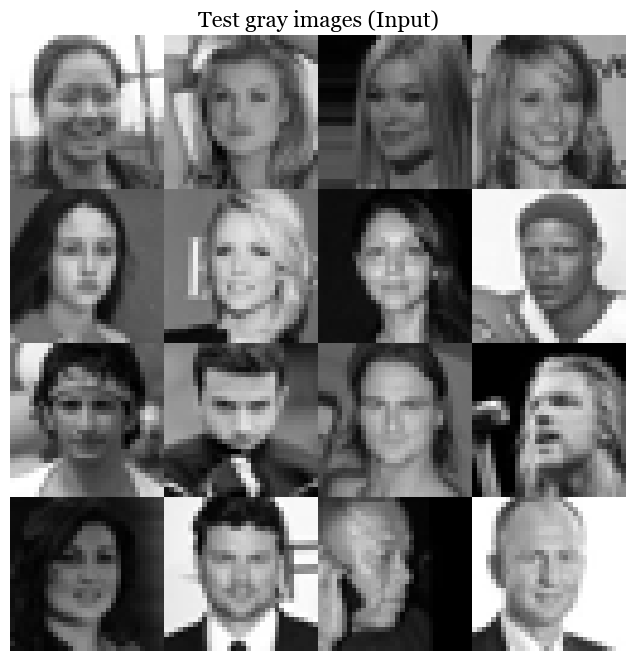

In [15]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)
imgs = x_test_gray[:16]
imgs = imgs.reshape((4, 4, img_rows, img_cols))
imgs_gray = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Test gray images (Input)',**csfont,fontsize=16)
plt.imshow(imgs_gray, interpolation='none', cmap='gray')
plt.show()

### Normalize and Reshape

In [16]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

### Network Parameters

In [18]:
img_rows = 32
img_cols = 32
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

### Encoder

In [20]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        640       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

### Decoder

In [21]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)       7379

### Combine into single model

In [22]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


### Setup Checkpoints, Learning Rate Adjustments, Optimizer, Loss Function and callbacks

In [23]:
save_dir = '../../data/cifar10/colorization/saved_models'
model_name = 'colorized_ae_model.{epoch:03d}.h5'
filepath = os.path.join(save_dir, model_name)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)
autoencoder.compile(loss='mse', optimizer='adam')
callbacks = [lr_reducer, checkpoint]

### Train Model

In [24]:
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=10,
                batch_size=batch_size,
                callbacks=callbacks)
x_decoded = autoencoder.predict(x_test_gray)

Epoch 1/10


2023-02-17 11:38:09.403599: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-17 11:38:10.197697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - ETA: 0s - loss: 0.0161

2023-02-17 11:38:32.039411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.00971, saving model to ../../data/cifar10/colorization/saved_models/colorized_ae_model.001.h5
1000/1000 [==============================] - 27s 24ms/step - loss: 0.0161 - val_loss: 0.0097 - lr: 0.0010
Epoch 2/10
 998/1000 [============================>.] - ETA: 0s - loss: 0.0087
Epoch 2: val_loss improved from 0.00971 to 0.00790, saving model to ../../data/cifar10/colorization/saved_models/colorized_ae_model.002.h5
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0087 - val_loss: 0.0079 - lr: 0.0010
Epoch 3/10
 998/1000 [============================>.] - ETA: 0s - loss: 0.0076
Epoch 3: val_loss improved from 0.00790 to 0.00722, saving model to ../../data/cifar10/colorization/saved_models/colorized_ae_model.003.h5
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0076 - val_loss: 0.0072 - lr: 0.0010
Epoch 4/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 4: val_loss improved from

2023-02-17 11:42:11.511631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 4s 15ms/step


### Display the result

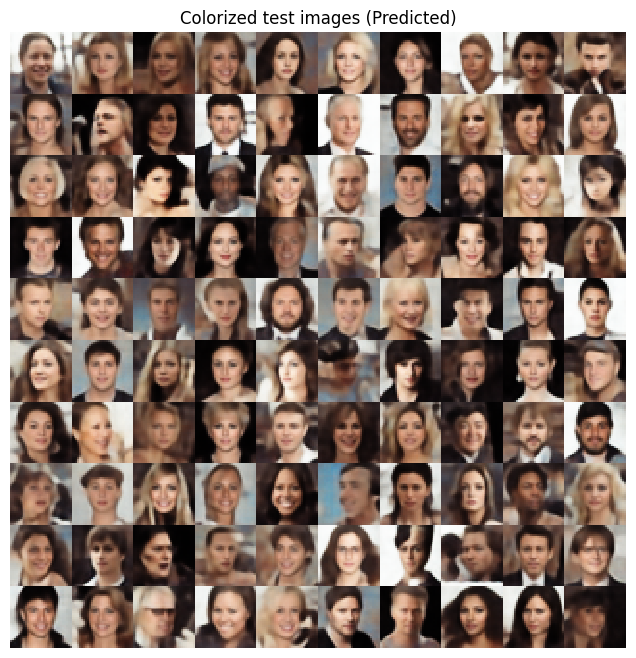

In [25]:
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs_colorized = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs_colorized, interpolation='none')
plt.show()

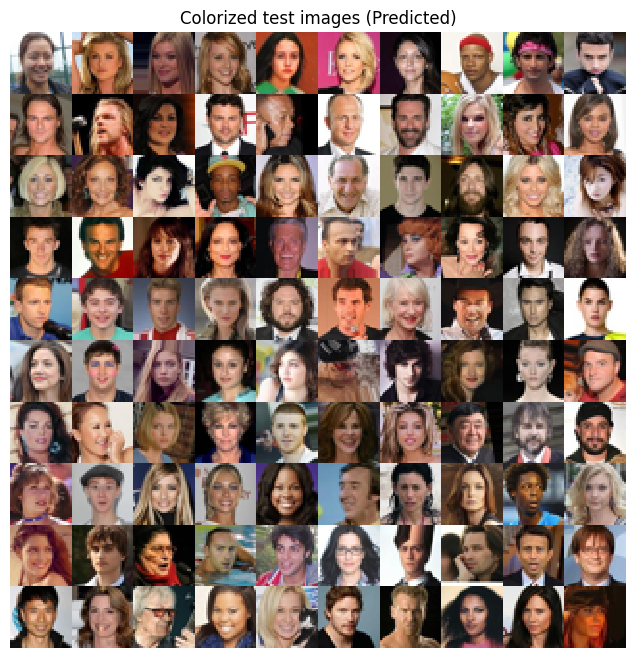

In [27]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs_colorized = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs_colorized, interpolation='none')
plt.show()